### This is the notebook I used for my Econometrics final project in Fall 2022

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as web
import datetime as dt
import statsmodels.api as sm
import seaborn as sb
import matplotlib.pyplot as plt
import statsmodels.stats.diagnostic as smd
import statsmodels.tsa.stattools as stools
import statsmodels.graphics.gofplots as qqplot
import statsmodels.stats.stattools as stools2

In [ ]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

## Gathering and Preparation of Exogenous variables for Regression - Select Macroeconmic measures 

In [82]:
data_codes = {"IP": "INDPRO",
              "EI": "EXPINF1YR",
              "I": "CORESTICKM159SFRBATL",
              "UPR": "BAA10Y",
              "LGB": "IRLTLT01USM156N",
              "TB": "DGS10",  
              "OP": "DCOILWTICO"}

In [83]:
# pull macroeconomic variables 
start = dt.datetime(1980, 1, 1)
end = dt.datetime(2022, 12, 1)
data = pd.DataFrame(columns = data_codes.keys())
for key, val in data_codes.items(): 
    dataset = web.DataReader(val, 'fred', start, end)[val]
    data[key] = dataset

In [84]:
# unexpected inflation measure - actual inflation minus expected 
data["UI"] = data["I"] - np.power(data["EI"].shift(-12), 1/12)

In [85]:
# unexpected changes in term structure 
data["UTS"] = data["LGB"] - data["TB"].shift(-1)

In [86]:
# pull S&P500 data 
sp500 = web.DataReader("^GSPC", "yahoo", start, end)
data["SP500"] = sp500["Adj Close"]

In [87]:
data= data.dropna()
#log the vars that arent already rates 
log_vars = ["PCE", "OP", "IP", "SP500"]
for key in data.keys(): 
    if key in log_vars: 
        data["log"+key] = np.log(data[key])
        data["d"+key] = data["log"+key].diff(1)
    else: 
        data["d"+key] = data[key].diff(1)

Text(0.5, 1.0, 'Trends of Macroeconomic Measures, 1986-2022')

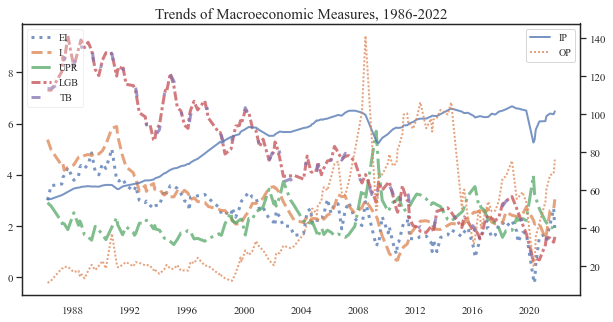

In [377]:
# plot macroeconmic data - non differenced
sb.set_style("white")
fig, ax = plt.subplots(figsize = (10, 5))
ax2 = ax.twinx()
linestyles = ['solid', 'dotted', 'dashed','dashdot', (0, (3, 1, 1, 1)), (0, (3, 10, 1, 10)), (0, (1, 1)) ]
for style, key in zip(linestyles, data_codes.keys()): 
    if key == "IP" or key == "OP": 
           ax2.plot(data[key].dropna(), label=key, lw=2, alpha=.75,ls=style)
    else: 
        ax.plot(data[key].dropna(), label=key, lw=3, alpha=.75,ls=style)
ax.legend(fontsize=10, loc='upper left', markerscale=5, framealpha=.3)
ax2.legend(fontsize=10, markerscale=5)
ax.set_title("Trends of Macroeconomic Measures, 1986-2022", fontsize = 15)

In [275]:
# define relevant vars to be used in regressions - obtain correlation matrix
exog_vars = ["dIP", "dEI", "dUPR", "dUI","dUTS", "dOP", "dSP500"]
reg_data = data[exog_vars].dropna()
reg_data.corr().round(3).to_excel("datacorr.xlsx")
reg_data.corr()

,dIP,dEI,dUPR,dUI,dUTS,dOP,dSP500
dIP,1.000000,0.502985,-0.605895,0.131978,0.070717,0.600455,0.556151
dEI,0.502985,1.000000,-0.519755,0.195431,0.109541,0.588752,0.289590
dUPR,-0.605895,-0.519755,1.000000,-0.034147,-0.214721,-0.513293,-0.624141
dUI,0.131978,0.195431,-0.034147,1.000000,0.185354,0.150323,-0.033776
dUTS,0.070717,0.109541,-0.214721,0.185354,1.000000,0.144103,-0.110511
dOP,0.600455,0.588752,-0.513293,0.150323,0.144103,1.000000,0.328476
dSP500,0.556151,0.289590,-0.624141,-0.033776,-0.110511,0.328476,1.000000


In [276]:
# obtain summary data of exogenous vars 
reg_data.describe().round(4).to_excel("exogvars_description.xlsx")
reg_data.describe().round(4)

,dIP,dEI,dUPR,dUI,dUTS,dOP,dSP500
count,148.0000,148.0000,148.0000,148.0000,148.0000,148.0000,148.0000
mean,0.0041,-0.0079,-0.0072,-0.0156,0.0010,0.0130,0.0197
std,0.0232,0.4379,0.4199,0.2366,0.2319,0.2064,0.0785
min,-0.1806,-1.7750,-1.2500,-0.6400,-0.8800,-1.0684,-0.4601
25%,-0.0002,-0.1915,-0.1600,-0.1298,-0.1600,-0.0620,-0.0047
50%,0.0051,0.0252,-0.0400,-0.0003,-0.0100,0.0331,0.0237
75%,0.0114,0.1995,0.1100,0.1051,0.1325,0.1068,0.0593
max,0.0609,1.0863,2.6400,0.8799,0.5900,0.6814,0.2471


<AxesSubplot:title={'center':'Distributions of the changes of Macro Variables'}, ylabel='Density'>

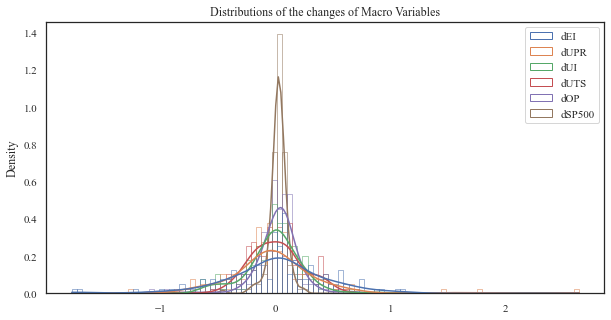

In [381]:
# plot distributions of macro-data 
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("Distributions of the changes of Macro Variables")
sb.histplot(data[exog_vars[1:]], stat="density",fill=False, kde=True, ax=ax)

In [111]:
# test model - SP500 regressed on macro-vars. Not included in paper. Pretty interesting. 
X = reg_data[["dIP", "dEI", "dUPR","dUTS", "dUI", "dOP"]]
Y = reg_data["dSP500"]
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()

In [112]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 dSP500   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     24.17
Date:                Tue, 06 Dec 2022   Prob (F-statistic):           1.52e-19
Time:                        08:25:53   Log-Likelihood:                 219.42
No. Observations:                 148   AIC:                            -424.8
Df Residuals:                     141   BIC:                            -403.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0146      0.005      3.066      0.0

<AxesSubplot:ylabel='Count'>

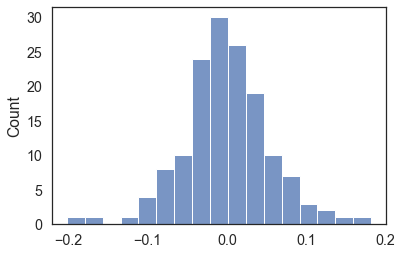

In [113]:
# checking residual plot of model - shoul dappear normally distributed 
sb.histplot(model.resid)

In [126]:
# testing for autocorrelation 
reg_data["u"] = model.resid
reg_data["u(t-1)"] = reg_data["u"].shift(-1).fillna(0)
X = reg_data[["dIP", "dEI", "dUPR", "dUI", "dOP","dUTS", "u(t-1)"]].dropna()
Y = reg_data["u"]
X = sm.add_constant(X)
SCtest_model = sm.OLS(Y, X).fit()

In [419]:
print(SCtest_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      u   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                    0.1135
Date:                Thu, 08 Dec 2022   Prob (F-statistic):              0.999
Time:                        11:55:56   Log-Likelihood:                 213.95
No. Observations:                 148   AIC:                            -409.9
Df Residuals:                     139   BIC:                            -382.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.317e-05      0.005      0.005      0.9

## Gathering and Preparation of Stock Data - All constituents of S&P500 pulled, put into respective sector

In [128]:
# define the constituents, sectors
sp500_constituents = pd.read_csv("sp500_constituents.csv")
sectors = sp500_constituents["Sector"].unique()
# not using Unnassigned sector 
sectors = sectors[:-1]
sector_constituents = {sector: [] for sector in sectors}
for sector in sectors: 
    sector_constituents[sector] = sp500_constituents["Ticker"][sp500_constituents["Sector"] == sector].values

In [129]:
sector_constituents

{'Information Technology': array(['AAPL', 'MSFT', 'NVDA', 'V', 'MA', 'AVGO', 'ACN', 'CSCO', 'ADBE',
        'CRM', 'INTC', 'QCOM', 'TXN', 'IBM', 'AMD', 'ORCL', 'INTU', 'NOW',
        'ADP', 'PYPL', 'AMAT', 'ADI', 'MU', 'FIS', 'LRCX', 'FISV', 'SNPS',
        'KLAC', 'ROP', 'CDNS', 'NXPI', 'FTNT', 'ADSK', 'APH', 'PAYX',
        'TEL', 'CTSH', 'MSI', 'HPQ', 'GPN', 'MCHP', 'ENPH', 'KEYS', 'GLW',
        'CDW', 'ANET', 'ANSS', 'ON', 'IT', 'TDY', 'EPAM', 'BR', 'HPE',
        'FLT', 'VRSN', 'ZBRA', 'MPWR', 'SEDG', 'SWKS', 'AKAM', 'TRMB',
        'NTAP', 'TER', 'PAYC', 'STX', 'TYL', 'WDC', 'JKHY', 'NLOK', 'CTXS',
        'PTC', 'QRVO', 'FFIV', 'JNPR', 'DXC', 'CDAY'], dtype=object),
 'Consumer Discretionary': array(['AMZN', 'TSLA', 'HD', 'MCD', 'NKE', 'LOW', 'SBUX', 'BKNG', 'TGT',
        'TJX', 'DG', 'GM', 'F', 'AZO', 'ORLY', 'MAR', 'CMG', 'DLTR', 'YUM',
        'HLT', 'ROST', 'APTV', 'EBAY', 'DHI', 'TSCO', 'ULTA', 'LEN', 'GPC',
        'KMX', 'DPZ', 'GRMN', 'DRI', 'EXPE', 'VFC', 'POOL', 'BBY'

In [130]:
# get number of companies in each sector 
sector_constituents_counts = {sector: pd.Series(sector_constituents[sector].shape[0]).iloc[0] for sector in sectors}

In [131]:
pd.DataFrame(sector_constituents_counts, index=["count"])

,Information Technology,Consumer Discretionary,Communication Services,Financials,Health Care,Energy,Consumer Staples,Utilities,Industrials,Materials,Real Estate
count,76,58,26,66,65,21,33,29,71,28,31


In [29]:
######### run once then save to .xlsx to pull later #################
# This algorithm takes > 5 minutes to complete; run carefully 

#stock_data = {}
#sectors = sp500_constituents["Sector"].unique()
#stock_data = {sector: {} for sector in sectors}
#sector_data = {}
#for sector in sectors: 
#    stock_data[sector] = web.get_data_yahoo(sector_constituents[sector], start, end)["Adj Close"]

In [30]:
#with pd.ExcelWriter("SP_stock_data.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index
    # to store the dataframe in specified sheet
#    for sector in sectors: 
#        stock_data[sector].to_excel(writer, sheet_name=sector)
#        print(sector)

In [132]:
# pull data from existing XLSX that was created from running the two cells above this one
stock_data = {sector: {} for sector in sectors}
for sector in sectors: 
    stock_data[sector] = pd.read_excel("SP_stock_data.xlsx", sheet_name = sector, parse_dates=True, index_col=0)

In [133]:
# obtain log-changes for each sector 
sector_changes = {sector: pd.DataFrame() for sector in sectors}
for sector in sectors:
    for stock in stock_data[sector]:
        data2 = np.log(stock_data[sector][stock].reindex_like(data))
        data3 = data2.diff(1)
        sector_changes[sector][stock] = data3
    

In [134]:
# average the log-changes
avg_sector_changes = {df: sector_changes[df].mean(axis=1) for df in sector_changes.keys()}

Text(0.5, 1.0, 'Distributions of Average relative changes, by Sector ')

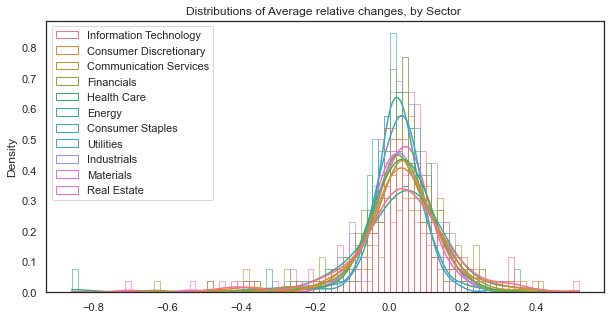

In [424]:
# show averages distributions
fig, ax = plt.subplots(figsize = (10,5))
sb.set(font_scale=1)
sb.set_style("white")
sb.histplot(avg_sector_changes,legend=True, fill=False, kde=True, stat="density", ax=ax)
ax.set_title("Distributions of Average relative changes, by Sector ")

In [426]:
# sector data descriptions 
avg_sector_changes_df = pd.DataFrame()
for sector in sectors: 
    avg_sector_changes_df[sector] = avg_sector_changes[sector]
avg_sector_changes_descriptions = avg_sector_changes_df.describe()
avg_sector_changes_descriptions.round(3).to_excel("avg_sector_changes.xlsx")
avg_sector_changes_descriptions.round(4)

,Information Technology,Consumer Discretionary,Communication Services,Financials,Health Care,Energy,Consumer Staples,Utilities,Industrials,Materials,Real Estate
count,148.0000,148.0000,148.0000,148.0000,148.0000,148.0000,148.0000,148.0000,148.0000,148.0000,148.0000
mean,0.0370,0.0334,0.0358,0.0282,0.0335,0.0237,0.0287,0.0225,0.0292,0.0260,0.0286
std,0.1367,0.1193,0.1076,0.1060,0.0878,0.1539,0.0658,0.0744,0.0956,0.0980,0.1012
min,-0.4464,-0.4763,-0.4901,-0.6344,-0.3532,-0.8590,-0.2341,-0.3679,-0.4831,-0.5351,-0.7032
25%,-0.0159,-0.0099,-0.0071,-0.0084,-0.0155,-0.0242,-0.0032,-0.0112,-0.0086,-0.0144,-0.0071
50%,0.0364,0.0352,0.0411,0.0259,0.0333,0.0407,0.0281,0.0290,0.0297,0.0288,0.0360
75%,0.1007,0.0930,0.0875,0.0884,0.0875,0.1006,0.0604,0.0635,0.0864,0.0807,0.0778
max,0.5149,0.3922,0.4065,0.3345,0.2631,0.3533,0.2502,0.2918,0.2326,0.2811,0.3161


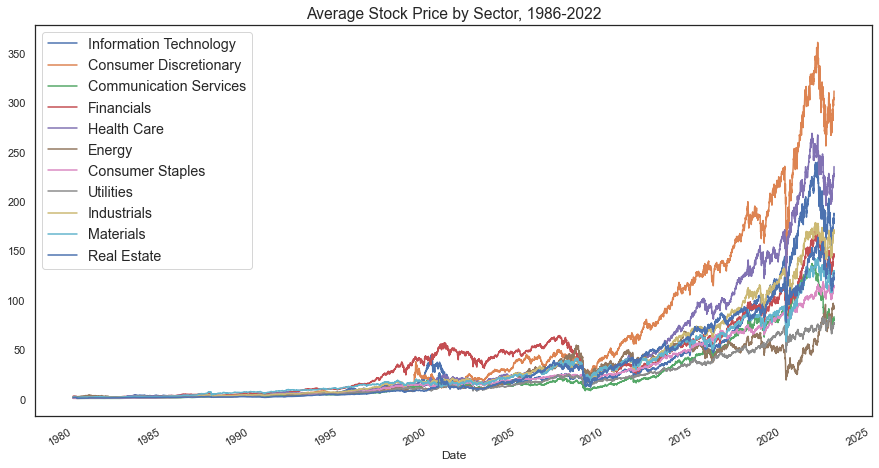

In [425]:
# line graph of average stock price by sector
fig, ax = plt.subplots(figsize=(15,8))
sb.set(font_scale=1.3)
sb.set_style("white")
for sector in sectors: 
    stock_data[sector].mean(axis=1).plot(ax=ax, title="Average Stock Price by Sector, 1986-2022", legend=True, label=sector)

## Model Building 

In [423]:
# create dictionary of regression results, serial correlation tests, correlation of error termns with exog vars 
results_dict = {}
SC_test_dict = {}
corr_matrices = pd.DataFrame()
for sector in sectors:
    #select variables to be included in the given sectors model 
    cleaning_vars = ["dIP", "dEI", "dUPR", "dUI","dUTS", "dOP", "dSP500", sector]
    data[sector] = avg_sector_changes[sector]
    reg_data = data[cleaning_vars].dropna()
    X = reg_data[exog_vars]
    Y = reg_data[sector]
    X = sm.add_constant(X)
    #fit model, get robust se results 
    model = sm.OLS(Y, X).fit().get_robustcov_results()
    print(model.summary())
    results_dict[sector] = model
    #get residuals from each model ad regress on lagged residuals and exog vars 
    reg_data["u"] = model.resid
    reg_data["u(t-1)"] = reg_data["u"].shift(-1).fillna(0)
    X1 = reg_data[["dIP", "dEI", "dUPR", "dUI","dUTS", "dOP", "dSP500", "u(t-1)"]].dropna()
    Y1 = reg_data["u"]
    X1 = sm.add_constant(X1)
    SCtest_model = sm.OLS(Y1, X1).fit()
    SC_test_dict[sector] = SCtest_model
    # obtain corr matrices for errors and exog vars 
    corr_matrices[sector] = reg_data[["dIP", "dEI", "dUPR", "dUI","dUTS", "dOP", "dSP500", "u"]].corr()["u"]

                              OLS Regression Results                              
Dep. Variable:     Information Technology   R-squared:                       0.702
Model:                                OLS   Adj. R-squared:                  0.687
Method:                     Least Squares   F-statistic:                     32.32
Date:                    Thu, 08 Dec 2022   Prob (F-statistic):           2.35e-26
Time:                            12:03:23   Log-Likelihood:                 174.69
No. Observations:                     148   AIC:                            -333.4
Df Residuals:                         140   BIC:                            -309.4
Df Model:                               7                                         
Covariance Type:                      HC1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

                            OLS Regression Results                            
Dep. Variable:            Industrials   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     74.55
Date:                Thu, 08 Dec 2022   Prob (F-statistic):           4.36e-44
Time:                        12:03:24   Log-Likelihood:                 253.41
No. Observations:                 148   AIC:                            -490.8
Df Residuals:                     140   BIC:                            -466.8
Df Model:                           7                                         
Covariance Type:                  HC1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0095      0.004      2.332      0.0

In [312]:
# errors are not correlated with exog vars at all 
corr_matrices.round(4)

,Information Technology,Consumer Discretionary,Communication Services,Financials,Health Care,Energy,Consumer Staples,Utilities,Industrials,Materials,Real Estate
dIP,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
dEI,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
dUPR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dUI,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
dUTS,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0
dOP,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
dSP500,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
u,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [222]:
dfuller_results = pd.DataFrame(index=["ADF Test Stat", "p-value" ])
for dat in data[exog_vars]:
    dfuller_results[dat] = stools.adfuller(data[dat].dropna(), regression="ct")[:2]

In [282]:
dfuller_results.round(4).to_excel("adfullerresults.xlsx")
dfuller_results.round(4)

,dIP,dEI,dUPR,dUI,dUTS,dOP,dSP500
ADF Test Stat,-10.4545,-7.3252,-7.5669,-9.3685,-6.9869,-10.5661,-7.4152
p-value,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [306]:
# collect relevant data to be shown in tables: se's, coefs, pvals, Rsq, Sc test results, residuals, bp tests, DW
index_vars = ["const", *exog_vars]
data["const"] = 1
sector_param_vals = pd.DataFrame(index=index_vars)
sector_p_vals = pd.DataFrame(index=index_vars)
sector_f_vals = pd.DataFrame()
sector_sc_test_pvals = pd.DataFrame()
sector_sc_test_params = pd.DataFrame()
se_dict = pd.DataFrame(index = index_vars)
bp_dict = pd.DataFrame(index=["LM", "LM p-val", "F", "F p-val"])
reg_results_summary = pd.DataFrame(index = ["R-Squared", "Adj. R-Squared","F-Value","F p-value", "Durbin-Watson", "Sample Size" ])
resids_df = pd.DataFrame()
for sector in sectors: 
    r = results_dict[sector]
    avg_sector_changes_descriptions[sector] = avg_sector_changes[sector].describe()
    sector_param_vals[sector] = r.params
    sector_p_vals[sector] = r.pvalues
    sector_f_vals[sector] = r.fvalue
    sector_sc_test_pvals[sector] = SC_test_dict[sector].pvalues
    sector_sc_test_params[sector] = SC_test_dict[sector].params
    bp_dict[sector] = smd.het_breuschpagan(r.resid, data[index_vars].dropna())
    resids_df[sector] = r.resid
    reg_results_summary[sector] = [r.rsquared,
                                   r.rsquared_adj,
                                   r.fvalue,
                                   r.f_pvalue,
                                   stools2.durbin_watson(r.resid),
                                   r.nobs]
    se_dict[sector] = r.bse

In [297]:
# save standard errors to construct results table in excel 
se_dict.round(3)
se_table = pd.DataFrame(columns=se_dict.keys(), index = index_vars)
for key in se_dict.round(3).keys(): 
    for i, val in enumerate(se_dict[key]): 
        se_table[key][i] = "("+str(round(val, 3))+")"
se_table

,Information Technology,Consumer Discretionary,Communication Services,Financials,Health Care,Energy,Consumer Staples,Utilities,Industrials,Materials,Real Estate
const,(0.007),(0.007),(0.005),(0.005),(0.004),(0.007),(0.004),(0.005),(0.004),(0.005),(0.005)
dIP,(0.378),(0.793),(0.364),(0.312),(0.231),(0.744),(0.336),(0.35),(0.262),(0.313),(0.335)
dEI,(0.016),(0.014),(0.013),(0.013),(0.012),(0.024),(0.011),(0.015),(0.012),(0.013),(0.015)
dUPR,(0.032),(0.027),(0.022),(0.017),(0.014),(0.035),(0.016),(0.02),(0.018),(0.02),(0.023)
dUI,(0.03),(0.029),(0.018),(0.023),(0.018),(0.027),(0.018),(0.021),(0.017),(0.022),(0.022)
dUTS,(0.032),(0.033),(0.024),(0.021),(0.019),(0.034),(0.017),(0.023),(0.02),(0.023),(0.024)
dOP,(0.042),(0.047),(0.032),(0.033),(0.039),(0.051),(0.027),(0.033),(0.026),(0.034),(0.043)
dSP500,(0.142),(0.151),(0.107),(0.081),(0.063),(0.167),(0.093),(0.126),(0.072),(0.095),(0.104)


In [298]:
se_table.to_excel("se_coef.xlsx")

<AxesSubplot:title={'center':"Residual Plots for Each Sector's Model"}, ylabel='Density'>

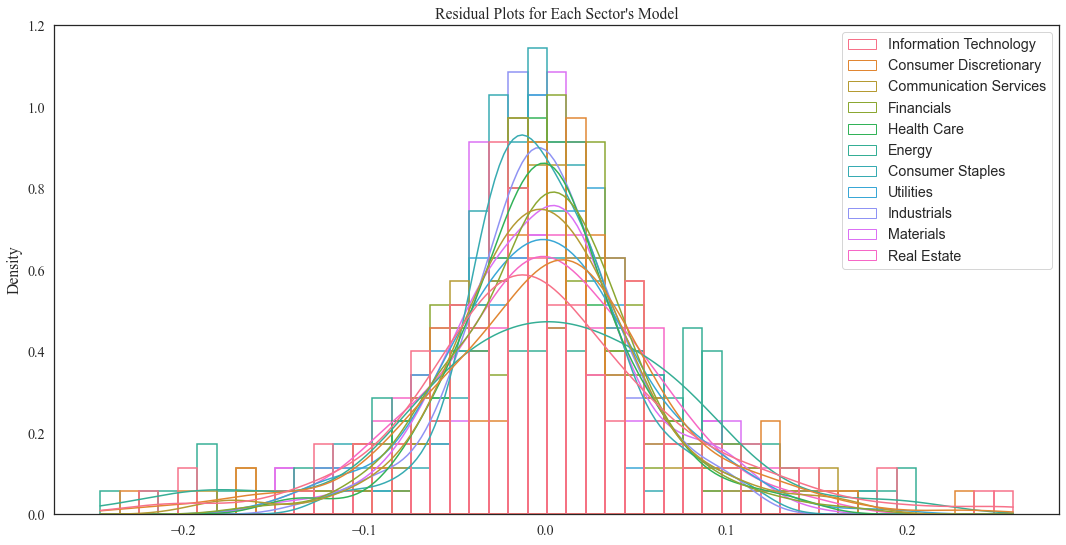

In [415]:
# residual distributions of each model; all should be normally distributed 
fig, ax = plt.subplots(figsize=(18,9
                               ))
ax.set_title("Residual Plots for Each Sector's Model")
sb.set_style("white")
sb.histplot(resids_df, stat="density", fill=False, legend=True, kde=True, ax = ax)

In [427]:
# breusch pagan results 
bp_dict.round(3)

,Information Technology,Consumer Discretionary,Communication Services,Financials,Health Care,Energy,Consumer Staples,Utilities,Industrials,Materials,Real Estate
LM,7.824,16.439,11.491,4.741,5.020,6.641,14.076,11.728,6.865,10.115,11.346
LM p-val,0.348,0.021,0.119,0.692,0.658,0.467,0.050,0.110,0.443,0.182,0.124
F,1.116,2.499,1.684,0.662,0.702,0.940,2.102,1.721,0.973,1.467,1.661
F p-val,0.356,0.019,0.118,0.704,0.670,0.478,0.047,0.109,0.454,0.184,0.124


# Results 

In [192]:
# model summary data 
reg_results_summary.round(3)

,Information Technology,Consumer Discretionary,Communication Services,Financials,Health Care,Energy,Consumer Staples,Utilities,Industrials,Materials,Real Estate
R-Squared,0.702,0.679,0.734,0.770,0.708,0.733,0.594,0.440,0.790,0.735,0.678
Adj. R-Squared,0.687,0.663,0.721,0.759,0.693,0.719,0.573,0.412,0.780,0.721,0.662
F-Value,32.319,20.885,62.121,58.088,66.570,30.471,18.869,14.159,74.552,50.025,15.965
F p-value,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Durbin-Watson,1.903,1.784,2.061,1.695,1.898,2.059,1.780,2.121,1.812,1.768,1.819
Sample Size,148.000,148.000,148.000,148.000,148.000,148.000,148.000,148.000,148.000,148.000,148.000


In [193]:
reg_results_summary.round(3).to_excel("reg_summaries.xlsx")

In [213]:
# paramter values, combine with se results, most importyant table in this analysis 
sector_param_vals.round(3).to_excel("sector_param_values.xlsx")
sector_param_vals.round(3)

,Information Technology,Consumer Discretionary,Communication Services,Financials,Health Care,Energy,Consumer Staples,Utilities,Industrials,Materials,Real Estate
const,0.011,0.009,0.013,0.005,0.016,0.001,0.015,0.011,0.009,0.009,0.010
dIP,-0.905,1.333,0.293,0.907,-0.747,0.663,0.219,0.831,0.275,-0.137,1.315
dEI,-0.000,-0.031,-0.033,-0.026,0.007,-0.051,-0.003,-0.014,-0.012,-0.025,-0.040
dUPR,-0.035,-0.036,-0.017,-0.031,0.008,-0.063,0.019,-0.015,-0.035,-0.054,-0.060
dUI,-0.014,-0.036,-0.007,0.028,0.007,0.041,0.026,0.030,0.015,0.006,0.033
dUTS,-0.010,-0.018,-0.046,0.004,0.007,-0.016,-0.011,-0.031,-0.009,-0.019,-0.005
dOP,-0.044,-0.151,0.006,-0.047,-0.014,0.371,-0.063,-0.024,-0.031,0.087,-0.034
dSP500,1.498,1.010,1.087,0.992,1.072,0.765,0.700,0.441,0.956,0.835,0.664


In [190]:
# corresponding p-vals 
sector_p_vals.round(4).to_excel("sector_p_values.xlsx")
sector_p_vals.round(4)

,Information Technology,Consumer Discretionary,Communication Services,Financials,Health Care,Energy,Consumer Staples,Utilities,Industrials,Materials,Real Estate
dIP,0.0179,0.0950,0.4227,0.0042,0.0015,0.3745,0.5154,0.0190,0.2960,0.6622,0.0001
dEI,0.9824,0.0311,0.0116,0.0462,0.5513,0.0323,0.7518,0.3308,0.3171,0.0615,0.0096
dUPR,0.2692,0.1829,0.4542,0.0669,0.5820,0.0749,0.2412,0.4642,0.0533,0.0067,0.0114
dUI,0.6364,0.2159,0.7006,0.2303,0.7200,0.1289,0.1502,0.1517,0.3931,0.8018,0.1414
dUTS,0.7509,0.5893,0.0525,0.8572,0.7251,0.6448,0.4959,0.1833,0.6622,0.4102,0.8274
dOP,0.2990,0.0015,0.8638,0.1540,0.7245,0.0000,0.0214,0.4638,0.2413,0.0110,0.4284
dSP500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0006,0.0000,0.0000,0.0000


In [304]:
# SC test results 
sector_sc_test_pvals.round(4).to_excel("serial_corr_test_pvals.xlsx")
sector_sc_test_pvals.round(4)


,Information Technology,Consumer Discretionary,Communication Services,Financials,Health Care,Energy,Consumer Staples,Utilities,Industrials,Materials,Real Estate
const,0.9932,0.9581,0.9907,0.9466,0.9926,0.9864,0.9924,0.9812,0.9503,0.9694,0.9964
dIP,0.9646,0.8300,0.9871,0.9368,0.9792,0.9156,0.9741,0.9496,0.9940,0.9668,0.9569
dEI,0.9530,0.8211,0.9526,0.9346,0.9927,0.9999,0.9921,0.9250,0.8834,0.9510,0.9432
dUPR,0.9974,0.9626,0.9724,0.9313,0.9846,0.9941,0.9690,0.9925,0.8687,0.9711,0.9759
dUI,0.9793,0.9976,0.9978,0.9218,0.9610,0.9923,0.9459,0.9291,0.9439,0.9829,0.9614
dUTS,0.9698,0.8840,0.9631,0.9970,0.9745,0.9939,0.9245,0.9310,0.8685,0.8939,0.9804
dOP,0.9290,0.7577,0.9630,0.9907,0.9996,0.9642,0.9652,0.9740,0.9038,0.8650,0.9342
dSP500,0.9429,0.9174,0.9999,0.8073,0.9963,0.9849,0.9768,0.9091,0.8192,0.9027,0.9789
u(t-1),0.6321,0.1816,0.6599,0.0669,0.5558,0.6853,0.2998,0.3805,0.2716,0.1796,0.3424
